In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set paths

CONTENT_DIR = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content"
STYLE_IMAGE_PATH = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/style/The_Visitor_by_Hennie_Niemann.jpg" # single image
SAVE_DIR = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/PSPM/visitor_training_outputs"
checkpoint_path = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/PSPM/visitor_training_outputs/pspm_visitor_checkpoint.pth"

In [ ]:
import os
if os.path.exists(CONTENT_DIR):
    print("Directory exists.")
else:
    print("Directory does NOT exist.")

Directory exists.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torchvision.datasets.folder import default_loader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import save_image
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# Gram Matrix for style loss
def gram_matrix(tensor):
    B, C, H, W = tensor.size()
    features = tensor.view(B, C, H * W)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (C * H * W)

In [ ]:
class FlatFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [
            os.path.join(folder_path, fname)
            for fname in os.listdir(folder_path)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Try to open and process the image
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, 0 #dummy label
        except Exception as e:
            print(f"Skipping {self.image_paths[idx]} (Unopenable: {e})")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # move to next image

In [ ]:
def load_content_image(img_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

In [ ]:
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features.eval()
        self.required = {'relu1_2': 3, 'relu2_2': 8, 'relu3_3': 17, 'relu4_3': 22}
        self.slice = nn.Sequential()
        for i in range(max(self.required.values()) + 1):
            self.slice.add_module(str(i), vgg[i])
        for param in self.slice.parameters():
            param.requires_grad = False

    def forward(self, x):
        out = {}
        for name, layer in self.slice._modules.items():
            x = layer(x)
            for key, idx in self.required.items():
                if int(name) == idx:
                    out[key] = x
        return out

In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.InstanceNorm2d(out_channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvLayer(channels, channels, 3, 1),
            ConvLayer(channels, channels, 3, 1),
        )

    def forward(self, x):
        return x + self.block(x)

class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scale_factor):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.conv = ConvLayer(in_channels, out_channels, kernel_size, 1)

    def forward(self, x):
        x = self.upsample(x)
        return self.conv(x)

class TransformerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            ConvLayer(32, 64, 3, 2),
            ConvLayer(64, 128, 3, 2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            UpsampleConvLayer(128, 64, 3, 2),
            UpsampleConvLayer(64, 32, 3, 2),
            nn.Conv2d(32, 3, 9, 1, padding=4)
            # No tanh activation —> output stays unbounded
        )

    def forward(self, x):
        return self.model(x)  # Clamp later

In [ ]:
def total_variation_loss(x):
    return torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) + \
           torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))

def compute_losses(vgg, output, content, style_features, content_weight, style_weight, tv_weight):
    out_feats = vgg(output)
    content_feats = vgg(content)

    content_loss = F.mse_loss(out_feats['relu2_2'], content_feats['relu2_2'])

    style_loss = 0
    for layer in style_features:
        G_out = gram_matrix(out_feats[layer])
        G_style = style_features[layer]
        style_loss += F.mse_loss(G_out, G_style)

    tv_loss = total_variation_loss(output)

    total_loss = (content_weight * content_loss +
                  style_weight * style_loss +
                  tv_weight * tv_loss)
    return total_loss

In [ ]:
def load_style_image(style_path, transform):
    img = Image.open(style_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    return img

In [ ]:
def train_style_transfer(transformer, dataloader, style_img, epochs=2,
                         content_weight=1.0, style_weight=2e5, tv_weight=1e-6,
                         lr=1e-3, save_dir=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transformer.to(device)
    optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

    vgg = VGGFeatures().to(device).eval()
    style_img = style_img.to(device)
    style_feats = vgg(style_img)
    style_grams = {k: gram_matrix(v).detach() for k, v in style_feats.items()}

    content_losses, style_losses, total_losses = [], [], []
    start_epoch = 0
    start_batch = 0

    # Resume from checkpoint if exists
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        transformer.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        start_batch = checkpoint.get('batch', 0)
        content_losses = checkpoint.get('content_losses', [])
        style_losses = checkpoint.get('style_losses', [])
        total_losses = checkpoint.get('total_losses', [])
        print(f"Resuming from epoch {start_epoch}, batch {start_batch}")

    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}...")
        transformer.train()

        for batch_idx, (batch, _) in enumerate(dataloader):
            if epoch == start_epoch and batch_idx < start_batch:
                continue  # Skip already seen batches

            content = batch.to(device)
            output = transformer(content)
            out_feats = vgg(output)
            content_feats = vgg(content)

            content_loss = F.mse_loss(out_feats['relu2_2'], content_feats['relu2_2'])

            style_loss = 0
            for layer in style_grams:
                G_style = style_grams[layer]
                G_out_batch = gram_matrix(out_feats[layer])
                for i in range(G_out_batch.size(0)):
                    G_out_i = G_out_batch[i].unsqueeze(0)
                    style_loss += F.mse_loss(G_out_i, G_style)
            style_loss /= G_out_batch.size(0)

            tv_loss = total_variation_loss(output)
            total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            content_losses.append(content_loss.item())
            style_losses.append(style_loss.item())
            total_losses.append(total_loss.item())

            if batch_idx % 300 == 0:
                print(f"  Batch {batch_idx+1}/{len(dataloader)} - "
                      f"Content: {content_loss.item():.4f}, "
                      f"Style: {style_loss.item():.4f}, "
                      f"Total: {total_loss.item():.4f}")

                transformer.eval()
                with torch.no_grad():
                    output_batch = transformer(content).cpu()

                for i in range(min(3, output_batch.size(0))):
                    out = deprocess(output_batch[i])
                    plt.figure(figsize=(3, 3))
                    plt.imshow(out)
                    plt.title(f"Stylized Sample {i+1} (Batch {batch_idx+1})")
                    plt.axis("off")
                    plt.show()

                transformer.train()

            # Save checkpoint every batch
            torch.save({
                'epoch': epoch,
                'batch': batch_idx + 1,
                'model': transformer.state_dict(),
                'optimizer': optimizer.state_dict(),
                'content_losses': content_losses,
                'style_losses': style_losses,
                'total_losses': total_losses
            }, checkpoint_path)

        start_batch = 0  # Reset batch count after each epoch

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            torch.save(transformer.state_dict(), os.path.join(save_dir, f"transformer_epoch{epoch+1}.pth"))

    # Plot loss curves
    x = range(1, len(total_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(x, content_losses, label='Content Loss')
    plt.plot(x, style_losses, label='Style Loss')
    plt.plot(x, total_losses, label='Total Loss', linewidth=2)
    plt.xlabel('Batch #')
    plt.ylabel('Loss')
    plt.title('Training Losses per Batch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def deprocess(tensor):
    tensor = tensor.clone().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  # Unnormalize
    tensor = tensor.clamp(0, 1)   # Clamp to [0, 1]
    tensor = tensor.permute(1, 2, 0)  # CHW → HWC
    return (tensor.numpy() * 255).astype('uint8') # Convert to [0, 255] for display

# Load flat folder of images
content_dataset = FlatFolderDataset(folder_path=CONTENT_DIR, transform=transform)
content_loader = DataLoader(content_dataset, batch_size=4, shuffle=True)

# Load and preprocess style image
style_img = load_style_image(STYLE_IMAGE_PATH, transform)

# Initialize model
transformer = TransformerNet()

# Start training
train_style_transfer(
    transformer=transformer,
    dataloader=content_loader,
    style_img=style_img,
    epochs=2,
    save_dir=SAVE_DIR
)

# Save model to Google Drive
torch.save(transformer.state_dict(), "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/PSPM/visitor_pspm_model_hyp_c1.0_s200000.0_lr0.001.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "pspm_visitor_checkpoint.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(f"[Checkpoint Loaded] Epoch: {checkpoint['epoch']} | Batch: {checkpoint['batch']}")

In [ ]:
def deprocess_stylized_image(tensor):
    tensor = tensor.clone().cpu().squeeze(0)  # Remove batch dim: [1, 3, H, W] → [3, H, W]
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  # Unnormalize
    tensor = tensor.clamp(0, 1)   # Clamp to [0, 1]
    tensor = tensor.permute(1, 2, 0)  # CHW → HWC
    return (tensor.numpy() * 255).astype('uint8')  # Convert to [0, 255] for saving

In [ ]:
# Stylization function

import time

def stylize_image(model_path, style_image_path, content_image_path, output_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Measure runtime
    start_time = time.time()

    # Preprocessing transform
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load and preprocess content
    content_img = Image.open(content_image_path).convert("RGB")
    content_tensor = transform(content_img).unsqueeze(0).to(device)

    # Load and preprocess style
    style_tensor = None
    if style_image_path:
        style_img = Image.open(style_image_path).convert("RGB")
        style_tensor = transform(style_img).unsqueeze(0).to(device)

    # Load trained model
    model = TransformerNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Stylize
    with torch.no_grad():
        stylized_tensor = model(content_tensor)

    # Compute content and style loss
    vgg = VGGFeatures().to(device).eval()
    output_feats = vgg(stylized_tensor)
    content_feats = vgg(content_tensor)
    content_loss = F.mse_loss(output_feats['relu2_2'], content_feats['relu2_2'])

    style_loss = 0
    if style_tensor is not None:
        style_feats = vgg(style_tensor)
        for layer in style_feats:
            G_s = gram_matrix(style_feats[layer])
            G_o = gram_matrix(output_feats[layer])
            style_loss += F.mse_loss(G_o, G_s)

    # Convert all images to numpy
    content_np = deprocess_stylized_image(content_tensor)
    style_np = deprocess_stylized_image(style_tensor) if style_tensor is not None else None
    stylized_np = deprocess_stylized_image(stylized_tensor)

    # Plot all images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(content_np)
    plt.title("Content")
    plt.axis("off")

    if style_np is not None:
        plt.subplot(1, 3, 2)
        plt.imshow(style_np)
        plt.title("Style")
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(stylized_np)
    plt.title("Stylized")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Save output
    if output_path:
        Image.fromarray(stylized_np).save(output_path)
        print(f"Stylized image saved to: {output_path}")

    # Print losses and runtime
    print(f"Content Loss: {content_loss.item():.4f}")
    if style_tensor is not None:
        print(f"Style Loss: {style_loss.item():.4f}")
    print(f"Runtime: {time.time() - start_time:.2f} seconds")


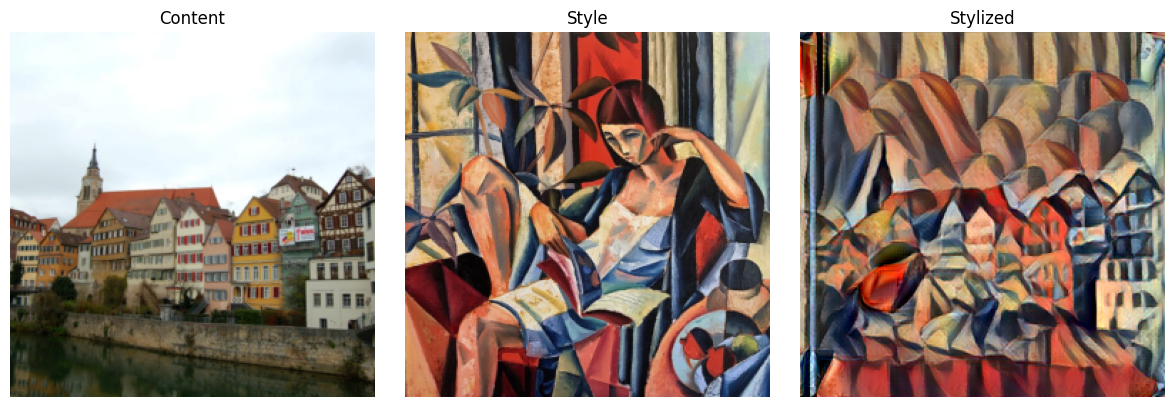

Stylized image saved to: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/PSPM/houses_content_x_visitor_stylized.jpg
Content Loss: 8.3012
Style Loss: 0.0000
Runtime: 2.22 seconds


In [ ]:
stylize_image(
    model_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/PSPM/visitor_pspm_model_hyp_c1.0_s200000.0_lr0.001.pth",
    style_image_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/style/The_Visitor_by_Hennie_Niemann.jpg",
    content_image_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/PSPM/houses_content.jpg",
    output_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/PSPM/houses_content_x_visitor_stylized.jpg")